In [1]:
import twitter, datetime
import json
import pymongo
from dotenv import load_dotenv 
import os 
import pandas
import preprocessor as p
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv()                  

mongo = os.environ.get('mongo')
db = os.environ.get('db')
topics = ["ModernaVaccine","JohnsonAndJohnsonVaccine", "PfizerVaccine"]

def oauth_login():
    '''
    A static method to authenticate user
    It uses OAuth2.0 specification which takes a bearer token to authenticate user
    '''

    CONSUMER_KEY = os.environ.get('CONSUMER_KEY')
    CONSUMER_SECRET = os.environ.get('CONSUMER_SECRET')
    BEARER_TOKEN= os.environ.get('BEARER_TOKEN')
    
    auth = twitter.OAuth2(CONSUMER_KEY, CONSUMER_SECRET, BEARER_TOKEN)
    api = twitter.Twitter(auth=auth)
    return api


def clean_results(result, topic):
    '''
    To take required text for NLP, may change later as per the requirement
    '''
    final = []
    for arr in result["statuses"]:
        obj = dict()
        obj["tweet"] = arr["text"]
        obj["id"] = arr["id_str"]
        obj["name"] = arr["user"]["name"]
        obj["location"] = arr["user"]["location"]
        obj["topic"] = topic
        obj["created_at"] = arr["created_at"]
        obj["processed_on"] = datetime.datetime.now().isoformat(' ', 'seconds')
        final.append(obj)
    return final


def save_tweets(tweets, topic):
    '''
    This method will help us on saving tweets
    '''
    client = pymongo.MongoClient(mongo)
    database = client[db]
    coll = database[topic]
    try:
        result = coll.insert_many(tweets)
        print("done inserting")
        return result
    except Exception as e:
        print(e)

def query_tweet(query, count, topic):
    '''
    Queries and finds tweet for different hashtags/topic, it will keep on searching until it finds total count
    '''
    api = oauth_login()
    result = api.search.tweets(q=query, count=500)
    print(result["search_metadata"])
    save_tweets(clean_results(result, topic), topic)
    result_count = result["search_metadata"]["count"]
    next_max_id = result["search_metadata"]["next_results"].split('max_id=')[1].split('&')[0]
    while result_count < count:
        result = api.search.tweets(q=query, include_entities='true',max_id=next_max_id, count=500 )
        print(result["search_metadata"])
        print(result_count)
        save_tweets(clean_results(result, topic), topic)
        result_count += result["search_metadata"]["count"]
        if "next_results" in result["search_metadata"]:
            next_max_id = result["search_metadata"]["next_results"].split('max_id=')[1].split('&')[0]
        else:
            break
        
def get_docs(col):
    '''
    This method is used to fetch the data from the mongodb server
    '''
    client = pymongo.MongoClient(mongo)
    database = client[db]
    coll = database[col]    
    try:
        result = coll.find()
        arr = []
        for r in result:
            arr.append(r)
        print("Retrieved" + col)
        return arr
    except Exception as e:
        print(e)

def get_docs_csv():
    client = pymongo.MongoClient(mongo)
    database = client[db]
    for col in topics:
        coll = database[col] 
        try:
            result = coll.find()
            
            fieldnames = list(result[0].keys())
            fieldnames.remove('_id')

            output_dir = os.path.join('data', 'csv')
            output_file = os.path.join(output_dir, col+'.csv')
            with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction="ignore")
                writer.writeheader()
                writer.writerows(result)

        except Exception as e:
            print(e)


def remove_punctuations(text):
    '''
    This method is used for text cleaning, some symbols like url, &, etc are removed 
    before it could send for text analysis
    '''
    punct =['%','/',':','\\','&amp;','&',';']
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text


def get_value_counts(col_name, analyzer_name, tweets_df):
    '''
    This function returns count of the dataset passed, it uses pands library to do the same
    '''
    count = pandas.DataFrame(tweets_df[col_name].value_counts())
    percentage = pandas.DataFrame(tweets_df[col_name].value_counts(normalize=True).mul(100))
    counts = pandas.concat([count, percentage], axis = 1)
    counts = counts.reset_index()
    counts.columns = ['sentiment', 'counts', 'percentage']
    counts.sort_values('sentiment', inplace = True)
    counts['percentage'] = counts['percentage'].apply(lambda x: round(x,2))
    counts = counts.reset_index(drop = True)
    counts['analyzer'] = analyzer_name
    return counts
   

In [3]:
def fetch_tweets():
    '''
    This method fetches and stores the tweets for the last seven days and store it in the mongodb
    '''
    try:
        topics = ["ModernaVaccine","JohnsonAndJohnsonVaccine", "PfizerVaccine"]
        for topic in topics:
            # query_tweet("#"+ topic+" -RT AND lang:en", 10000, topic)
            print("Done fetching tweets", topic)
    except Exception as e:
        print(e)

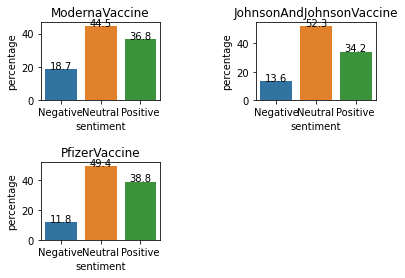

In [4]:
result_copy = ''
def generate_report():
    try:
        topics = ["ModernaVaccine","JohnsonAndJohnsonVaccine", "PfizerVaccine"]
        # topics = ["ModernaVaccine"]
        final = []
        for topic in topics:          
            # result_from_db = get_docs(topic)
            # result = pandas.DataFrame(result_from_db)

            file_dir = os.path.join('data', 'csv')
            file = os.path.join(file_dir, topic+'.csv')
            result = pandas.read_csv(file)

            result.head(20)

            result.sort_values(by="created_at")
            # print(result.head(n=5))
            result_copy = result.copy()
            result_copy['tweet_cleaned'] = result_copy['tweet'].apply(lambda x: p.clean(x))
            # print(result.head(n=5))
            # print(result_copy.head(n=5))
            # print(len(result_copy))
            result_copy.drop_duplicates(subset='tweet_cleaned', keep='first', inplace=True)
            # print(len(result_copy))

            # remove punctuations
            result_copy['tweet_cleaned'] = result_copy['tweet_cleaned'].apply(lambda x: remove_punctuations(x))

            # Drop tweets which have empty text field
            result_copy['tweet_cleaned'].replace('', np.nan, inplace=True)
            result_copy['tweet_cleaned'].replace(' ', np.nan, inplace=True)
            result_copy.dropna(subset=['tweet_cleaned'], inplace=True)
            # print(len(result_copy))
            # print(result_copy.head(n=5))

            result_copy = result_copy.reset_index(drop=True)
            # print(result_copy.sample(5))


            #sentiment analysis
            # Obtain polarity scores generated by TextBlob
            result_copy['textblob_score'] = result_copy['tweet_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
            # neutral_thresh = 0.05

            # Convert polarity score into sentiment categories
            result_copy['textblob_sentiment'] = result_copy['textblob_score'].apply(lambda c: 'Positive' if c >= 0.05 else ('Negative' if c <= -(0.05) else 'Neutral'))
            # print(result_copy['textblob_sentiment'].describe())
            
            textblob_sentiment_df = get_value_counts('textblob_sentiment','TextBlob', result_copy)
            # print(textblob_sentiment_df)

            final.append(textblob_sentiment_df)

        # finaly plotting
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.8, wspace=0.8)

        ax = fig.add_subplot(2, 2, 1)
        ax.set_title(topics[0])
        for index, row in final[0].iterrows():
                ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
        sns.barplot(x="sentiment", y="percentage", data=final[0], ax=ax,)

        ax = fig.add_subplot(2, 2, 2)
        ax.set_title(topics[1])
        for index, row in final[1].iterrows():
                ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
        sns.barplot(x="sentiment", y="percentage", data=final[1], ax=ax)

        ax = fig.add_subplot(2, 2, 3)
        ax.set_title(topics[2])
        for index, row in final[2].iterrows():
                ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
        sns.barplot(x="sentiment", y="percentage", data=final[2], ax=ax)

        plt.show()

    except Exception as e:
        print(e)

generate_report()
